# Looking for signals of attention (and other mental states) in macaque V2

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import utils

Invoking __init__.py for NDNT.utils


In [2]:
# load the data
data = utils.load_data('ki_0126_V2_py.mat')

../../data/hn/ ki_0126_V2_py.mat
Loaded ki_0126_V2_py.mat
190541 frames, 26 units, 870 trials with 192 frames each


# 1) fit model - autoencoder + GLM, 3 LVs

In [4]:
import model
reload(model)

import os.path
# only train if the model does not exist
if not os.path.isfile('model1.pickle'):
    # make the glm and train it
    # put the activation function at the end of this one since we are training it to produce the spikes
    pretrained_glm_layer = model.define_glm_layer(num_cells=data.NC, stim_dims=data.stim_dims, as_layer=False)
    pretrained_glm = model.NDN.NDN(layer_list = [pretrained_glm_layer], loss_type='poisson')
    model.fit_model(pretrained_glm, data)

    mean_lls_alone = []
    mean_lls_wglm = []

    num_latents = 3

    print('===== AUTOENCODER ALONE =====')
    lls_alone, latent_model = model.train_autoencoder(data, num_latents)
    # retrain if it started from a bad initialization
    while np.mean(lls_alone) < 0:
        print('LLs alone is BAD', str(np.mean(lls_alone)), 'RETRAINING')
        lls_alone, latent_model = model.train_autoencoder(data. num_latents)

    print('===== AUTOENCODER W/GLM =====')
    lls_wglm, pretrained_glm_plus_latent_model = model.train_autoencoder_and_glm(data, num_latents, pretrained_glm)
    # retrain if it started from a bad initialization
    while np.mean(lls_wglm) < 0 :
        print('LLs alone is BAD', str(np.mean(lls_wglm)), 'RETRAINING')
        lls_wglm, pretrained_glm_plus_latent_model = model.train_autoencoder_and_glm(data, num_latents, pretrained_glm)

    mean_lls_alone.append(np.mean(lls_alone))
    mean_lls_wglm.append(np.mean(lls_wglm))

    print('mean-adjusted LLs alone', np.mean(lls_alone))
    print('mean-adjusted LLs w/GLM', np.mean(lls_wglm))

In [5]:
# save out the model for later use
import pickle
if not os.path.isfile('model1.pickle'):
    with open('model1.pickle', 'wb') as f:
        pickle.dump(pretrained_glm_plus_latent_model, f)

# 2) analyze latents

In [6]:
# load the saved out latents
model = utils.load_model('model1.pickle')
R = utils.construct_R_matrix(data)
Z = utils.construct_Z_matrix(R, model, num_latents=3)
Z.shape # trials X time X latents

(870, 200, 3)

/tmp/ipykernel_18687/1907927604.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


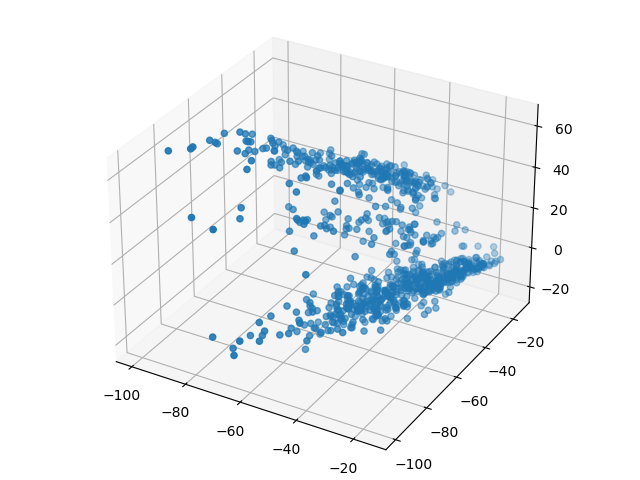

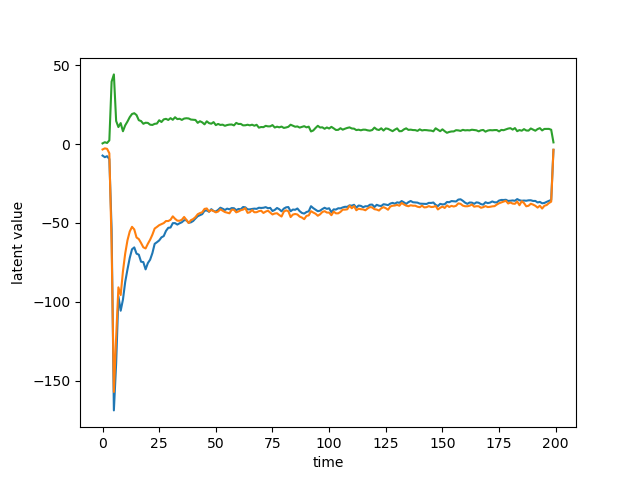

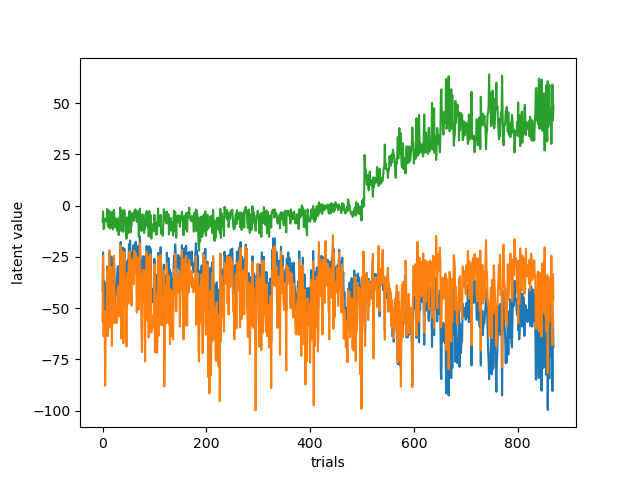

In [43]:
## 2a plotted 3 latents in 3D
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.mean(Z, axis=1).T[0],
           np.mean(Z, axis=1).T[1],
           np.mean(Z, axis=1).T[2])
plt.show()

## 2b plotted latents averaged over time
fig = plt.figure()
plt.plot(np.mean(Z, axis=0).T[0])
plt.plot(np.mean(Z, axis=0).T[1])
plt.plot(np.mean(Z, axis=0).T[2])
plt.xlabel("time")
plt.ylabel("latent value")
plt.show()

## 2c plotted latents averaged over trials
fig = plt.figure()
plt.plot(np.mean(Z, axis=1).T[0])
plt.plot(np.mean(Z, axis=1).T[1])
plt.plot(np.mean(Z, axis=1).T[2])
plt.xlabel("trials")
plt.ylabel("latent value")
plt.show()

# 3) determine cued vs. uncued vector as a proxy for attention

In [8]:
## 3a find centroids of latents for cued and uncued trials
trcued = np.where(data.TRcued < 0)[0]
truncued = np.where(data.TRcued > 0)[0]
trcued_mean = np.mean(np.mean(Z[trcued], axis=1), axis=0)
truncued_mean = np.mean(np.mean(Z[truncued], axis=1), axis=0)

## 3b calculate vector between the centroids
centroid_vector = trcued_mean - truncued_mean
centroid_vector /= np.sqrt(centroid_vector @ centroid_vector.T)
centroid_vector = np.array([centroid_vector])
centroid_vector

array([[ 0.72960741,  0.68260177, -0.04156731]])

In [9]:
## 3c fit logistic regression model between cued and uncued
# separate cued-uncued points via logistic regression instead of centroids
from sklearn.linear_model import LogisticRegression

cued_trial_model = LogisticRegression(random_state=0).fit(np.mean(Z, axis=1), data.TRcued)

## 3d calculate hyperplane vector
hyperplane_vector = (cued_trial_model.coef_ / np.sqrt(cued_trial_model.coef_ @ cued_trial_model.coef_.T))
hyperplane_vector

array([[-0.80096257,  0.40420791, -0.44167288]])

# 4) project latents onto cued vs. uncued vector

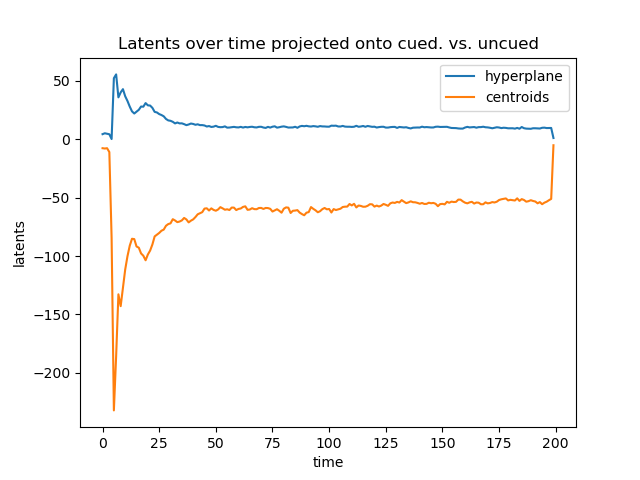

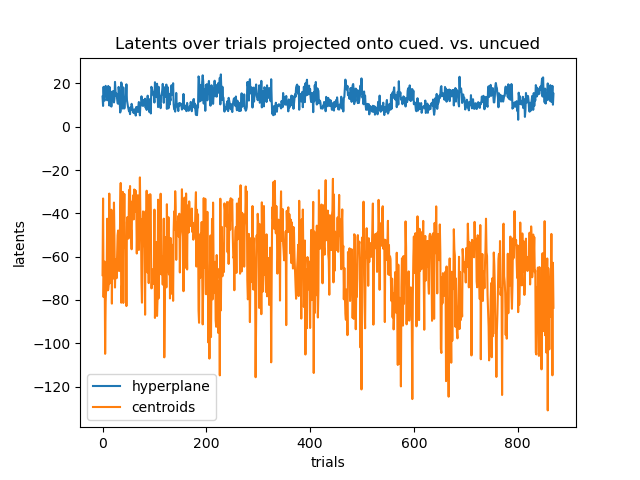

In [10]:
## 4a project the latents over time onto the cued vs. uncued vectors
fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z, axis=0).T).T, label="hyperplane")
plt.plot((centroid_vector @ np.mean(Z, axis=0).T).T, label="centroids")
plt.title("Latents over time projected onto cued. vs. uncued")
plt.xlabel("time")
plt.ylabel("latents")
plt.legend()
plt.show()

## 4b project the latents over trials onto the cued vs. uncued vectors
fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z, axis=1).T).T, label="hyperplane")
plt.plot((centroid_vector @ np.mean(Z, axis=1).T).T, label="centroids")
plt.title("Latents over trials projected onto cued. vs. uncued")
plt.xlabel("trials")
plt.ylabel("latents")
plt.legend()
plt.show()

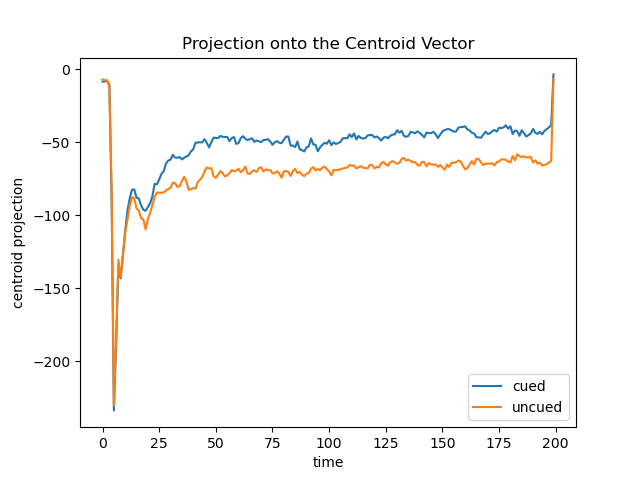

In [18]:
fig = plt.figure()
plt.plot((centroid_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((centroid_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("centroid projection")
plt.title("Projection onto the Centroid Vector")
plt.show()

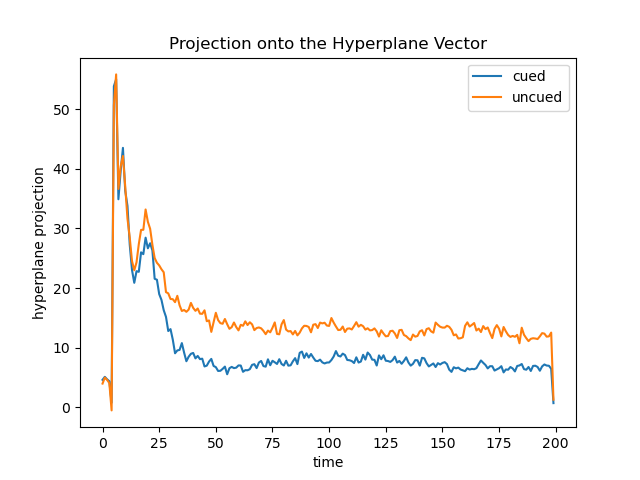

In [17]:
fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((hyperplane_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("hyperplane projection")
plt.title("Projection onto the Hyperplane Vector")
plt.show()

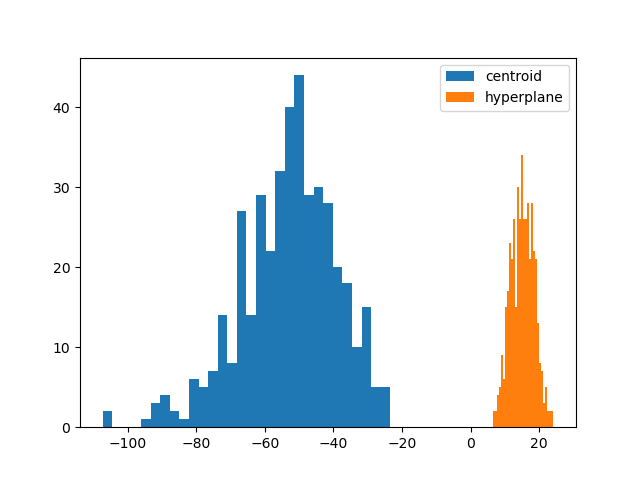

In [20]:
fig = plt.figure()
plt.hist((centroid_vector @ np.mean(Z[trcued], axis=1).T).T, bins=30, label="centroid")
plt.hist((hyperplane_vector @ np.mean(Z[truncued], axis=1).T).T, bins=30, label="hyperplane")
plt.legend()
plt.show()

# 5) why is there something interesting at timestep 500?

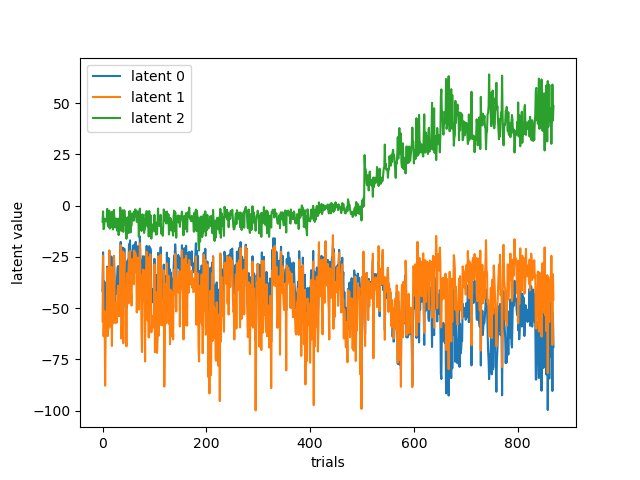

In [28]:
## 2c plotted latents averaged over trials
fig = plt.figure()
plt.plot(np.mean(Z, axis=1).T[0], label="latent 0")
plt.plot(np.mean(Z, axis=1).T[1], label="latent 1")
plt.plot(np.mean(Z, axis=1).T[2], label="latent 2")
plt.xlabel("trials")
plt.ylabel("latent value")
plt.legend()
plt.show()

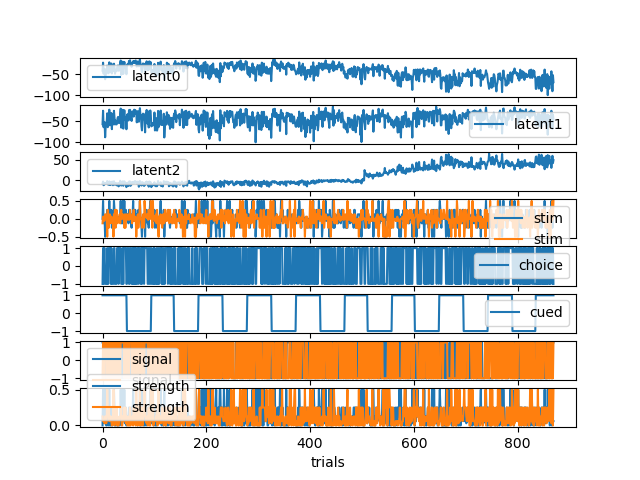

In [42]:
# plot latent2 along with other trial vars to see what correlates
latent0 = np.mean(Z, axis=1).T[0]
latent1 = np.mean(Z, axis=1).T[1]
latent2 = np.mean(Z, axis=1).T[2]
fig = plt.figure()
plt.subplot(8, 1, 1)
plt.plot(latent0, label="latent0")
plt.legend()
plt.subplot(8, 1, 2)
plt.plot(latent1, label="latent1")
plt.legend()
plt.subplot(8, 1, 3)
plt.plot(latent2, label="latent2")
plt.legend()
plt.subplot(8, 1, 4)
plt.plot(data.TRstim, label="stim")
plt.legend()
plt.subplot(8, 1, 5)
plt.plot(data.TRchoice, label="choice")
plt.legend()
plt.subplot(8, 1, 6)
plt.plot(data.TRcued, label="cued")
plt.legend()
plt.subplot(8, 1, 7)
plt.plot(data.TRsignal, label="signal")
plt.legend()
plt.subplot(8, 1, 8)
plt.plot(data.TRstrength, label="strength")
plt.legend()
plt.xlabel("trials")
plt.show()

# 6) determine vectors for other vars, such as strength, choice, correctness

# 7) retrain models with different #'s of latents

In [13]:
# 7a) determine D-prime between cued vs. uncued


# 8) retrain model with smoothed robs as inputs